In [152]:
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional,BatchNormalization
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [153]:
base_path = r'C:\projects\digit_prediction\tredence'
train_path = r'C:\projects\digit_prediction\tredence\data\train.csv'
test_path = r'C:\projects\digit_prediction\tredence\data\test.csv'

In [154]:
train_df = pd.read_csv(train_path)
print(train_df.shape)

(16644, 12)


In [155]:
train_df = train_df[~( (train_df['date'] >= '2017-01-01') & (train_df['date'] < '2019-01-01') )]

In [156]:
train_df['warehouse_ID'].unique()

array(['WH_0x3e9', 'WH_0x3ea', 'WH_0x3eb', 'WH_0x3ec', 'WH_0x3ed',
       'WH_0x3ee', 'WH_0x3ef', 'WH_0x3f1', 'WH_0x3f0', 'WH_0x3f2'],
      dtype=object)

## preprocessing

In [157]:
train_df['date'] = pd.to_datetime(train_df['date'],format='%Y-%m-%d')

In [158]:
train_df['is_weekend'] = train_df['date'].dt.weekday.apply(lambda x: 'Yes' if x >= 6 else 'No')


In [159]:
train_df.to_csv('tredence_non_null.csv',index=False)

In [160]:
def checkout(x):
    if x =='Yes':
        return 1.0
    elif x =='No':
        return 0.0
    else:
        return x
train_df['is_warehouse_closed'] = train_df['is_warehouse_closed'].apply(lambda x: checkout(x))
train_df['is_weekend'] = train_df['is_weekend'].apply(lambda x: checkout(x))
train_df['Product_Type'] = train_df['Product_Type'].apply(lambda x: 1 if x=='Type_A' else 0)
train_df['is_warehouse_closed'] = train_df['daily_dispatch_count'].apply(lambda x: 1 if x > 0.0 else 0)

 ## Analysis

<AxesSubplot:xlabel='date'>

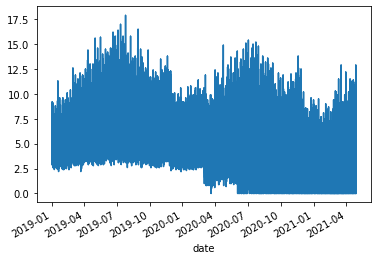

In [82]:
k = train_df['daily_dispatch_count']
k.index = train_df['date']
k.plot()

* For the pre pandemic years, the daily dispatch count used to be between 2.5~ 17.5
* Covid effect can be seen from june of 2020, where the range for warehouse became ~ 0-12.5

In [83]:
train_df.groupby(['warehouse_ID'])['date'].min()

warehouse_ID
WH_0x3e9   2019-01-01
WH_0x3ea   2019-01-01
WH_0x3eb   2019-01-01
WH_0x3ec   2019-01-01
WH_0x3ed   2019-01-02
WH_0x3ee   2019-05-02
WH_0x3ef   2020-01-02
WH_0x3f0   2020-05-02
WH_0x3f1   2020-02-02
WH_0x3f2   2020-06-02
Name: date, dtype: datetime64[ns]

<AxesSubplot:xlabel='year', ylabel='count'>

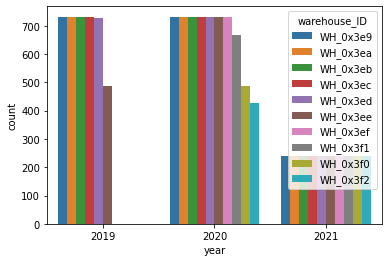

In [84]:
sns.countplot(x = train_df['year'],hue = train_df['warehouse_ID'])

* We can see addition of two new warehouses every year, i.e. in jan and may or june

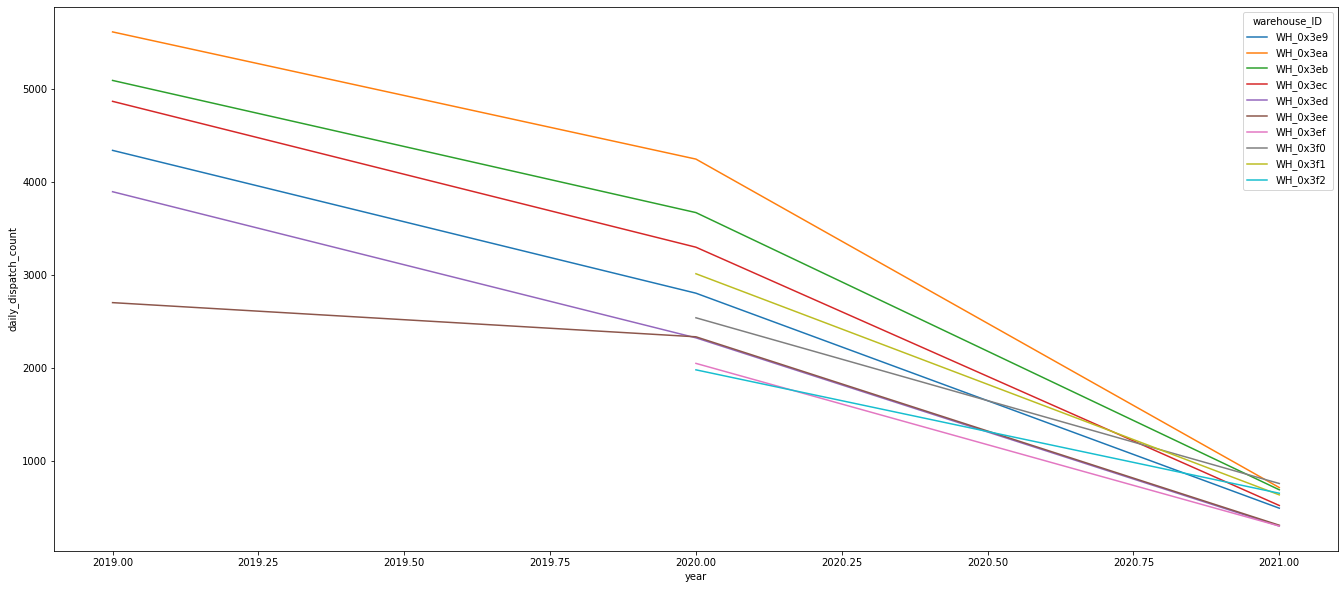

In [85]:
g = train_df.groupby(['warehouse_ID','year'], as_index=False)['daily_dispatch_count'].sum()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(23,10))
sns.lineplot(x=g['year'], y= g['daily_dispatch_count'], hue = g['warehouse_ID'],estimator='sum',legend='full',sort=True)
plt.show()

* warehouse e9 can be seen to have the highest daily_dispatch_count, then eb and ec since they joined earlier.
* A drastic decrease in the daily dispatch count can be seen after 2019.
* Until the 2021, all the warehouses can be seen to have equal dispatch rates post the begining of 2020.


In [86]:
q = train_df[(train_df['warehouse_ID'] == 'WH_0x3e9') & (train_df['year'] == 2019)]

print(np.mean(q[q['is_weekend']=='Yes']['daily_dispatch_count']))
print(np.mean(q[q['is_weekend']=='No']['daily_dispatch_count']))

q = train_df[(train_df['warehouse_ID'] == 'WH_0x3e9') & (train_df['year'] == 2020)]

print(np.mean(q[q['is_weekend']=='Yes']['daily_dispatch_count']))
print(np.mean(q[q['is_weekend']=='No']['daily_dispatch_count']))

q = train_df[(train_df['warehouse_ID'] == 'WH_0x3e9') & (train_df['year'] == 2021)]

print(np.mean(q[q['is_weekend']=='Yes']['daily_dispatch_count']))
print(np.mean(q[q['is_weekend']=='No']['daily_dispatch_count']))

nan
nan
nan
nan
nan
nan


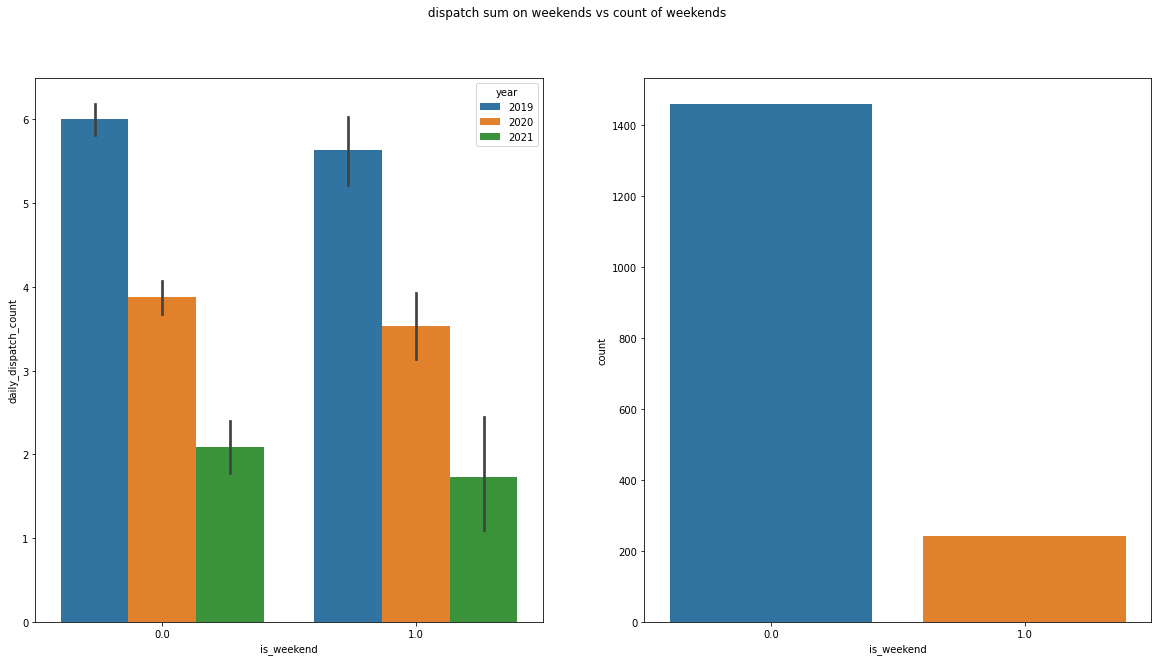

In [87]:
q = train_df[(train_df['warehouse_ID'] == 'WH_0x3e9')]
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))

fig.suptitle(' dispatch sum on weekends vs count of weekends')
sns.barplot(y = q['daily_dispatch_count'], x=q['is_weekend'],estimator=np.mean, hue=q['year'],ax=ax1)
sns.countplot(x = q['is_weekend'],ax=ax2)
plt.show()

* Although there are less weekends altogether in years, the average dispatch count on weekends and weekdays is same.

In [88]:
q.head(n=2)

,ID,date,warehouse_ID,Latitude,Longitude,Product_Type,year,month,is_weekend,is_warehouse_closed,daily_dispatch_count,weekly_dispatch_count
3404,0x2b56,2019-01-01,WH_0x3e9,41.681471,-72.794746,1,2019,January,0.0,1,5.7,NaN
3405,0x2b57,2019-01-01,WH_0x3e9,41.681471,-72.794746,0,2019,January,0.0,1,2.9,NaN


## Regression Analysis

In [89]:
q = train_df[train_df['warehouse_ID'] == 'WH_0x3e9']

In [90]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import chi2
crosstab = pd.crosstab(q['Product_Type'], q['is_weekend'])
stat, p, dof, expected = chi2_contingency(crosstab)
print('Degress of freedom = %d' % dof)
# print(expected)
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

if abs(stat) >= critical:
	print('Dependent (We reject H0)')
else:
	print('Independent (We fail to reject H0)')
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (We reject H0)')
else:
	print('Independent (We fail to reject H0)')


Degress of freedom = 1
probability=0.950, critical=3.841, stat=0.000
Independent (We fail to reject H0)
significance=0.050, p=1.000
Independent (We fail to reject H0)


* Product Type and is_weekend are not related.

In [91]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import chi2
crosstab = pd.crosstab(q['Product_Type'], q['month'])
stat, p, dof, expected = chi2_contingency(crosstab)
print('Degress of freedom = %d' % dof)
# print(expected)
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

if abs(stat) >= critical:
	print('Dependent (We reject H0)')
else:
	print('Independent (We fail to reject H0)')
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (We reject H0)')
else:
	print('Independent (We fail to reject H0)')


Degress of freedom = 11
probability=0.950, critical=19.675, stat=0.000
Independent (We fail to reject H0)
significance=0.050, p=1.000
Independent (We fail to reject H0)


* Product Type and month are not related

In [92]:

import statsmodels.api as sm
q = train_df[train_df['warehouse_ID'] == 'WH_0x3e9']
q = q.drop(['ID','date','Latitude','Longitude','is_warehouse_closed','weekly_dispatch_count','warehouse_ID'],axis=1)
month = pd.get_dummies(q['month'])
q.drop(['month'], axis=1,inplace=True)
q = pd.concat([q,month], axis=1)
x = q.drop(['daily_dispatch_count'], axis=1)
y = q['daily_dispatch_count']
mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     daily_dispatch_count   R-squared:                       0.683
Model:                              OLS   Adj. R-squared:                  0.680
Method:                   Least Squares   F-statistic:                     259.4
Date:                  Mon, 02 May 2022   Prob (F-statistic):               0.00
Time:                          23:37:16   Log-Likelihood:                -3191.0
No. Observations:                  1702   AIC:                             6412.
Df Residuals:                      1687   BIC:                             6494.
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Product_Type     3.5274     


* The model was able to explain ~68% of the observations.
* The p-values <0.05, indicates that we can reject Ho, i.e., the coefficient of the feature is could not equal to 0.0 or that the feature is related to dependent variable.
* The CI for year and weekend contains 0, i.e., these features could have negative effect on daily dispatch count, with an increase in year.

<AxesSubplot:xlabel='year', ylabel='daily_dispatch_count'>

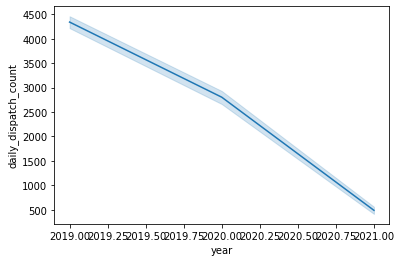

In [93]:
sns.lineplot(x = q['year'], y = q['daily_dispatch_count'], estimator=np.sum)

0.9915380477905273 2.380832242465658e-08


c:\projects\digit_prediction\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

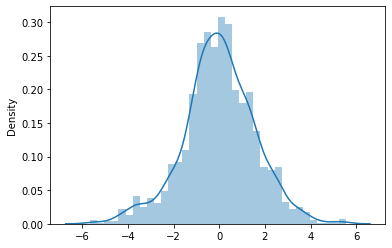

In [94]:
# sns.distplot(q['daily_dispatch_count'])

import scipy.stats as stats
w, pvalue = stats.shapiro(res.resid)
print(w, pvalue)
sns.distplot(res.resid)

* The normality of residuals shows the correctness or significance of model and CIs.


### Problem with Linear Regression
* The Linear regression correctly understood the pattern of decrease in disaptch count, increase an increase in year.
* However, this was due to increase in number of warehouses and covid effect.
* likely in future , the number of warehouses might or might not increase, but linear regression will keep reducing the dispatch count.
* Therefore, Linear regression helped in understanding current patterns of the data for further decision and deriving insights.
* It indicated that Product_Type and month can be useful for predictions and is_weekend likely not much useful.


In [95]:
q = train_df[train_df['warehouse_ID'] == 'WH_0x3e9']
q = q.drop(['ID','date','Latitude','Longitude','daily_dispatch_count','weekly_dispatch_count','warehouse_ID'],axis=1)
month = pd.get_dummies(q['month'])
q.drop(['month'], axis=1,inplace=True)
q = pd.concat([q,month], axis=1)
x = q.drop(['is_warehouse_closed'], axis=1)
y = q['is_warehouse_closed']
import statsmodels.api as sm
log_reg = sm.Logit(y, x).fit()
print(log_reg.summary())

         Current function value: 0.148250
         Iterations: 35
                            Logit Regression Results                           
Dep. Variable:     is_warehouse_closed   No. Observations:                 1702
Model:                           Logit   Df Residuals:                     1687
Method:                            MLE   Df Model:                           14
Date:                 Mon, 02 May 2022   Pseudo R-squ.:                  0.4253
Time:                         23:37:17   Log-Likelihood:                -252.32
converged:                       False   LL-Null:                       -439.05
Covariance Type:             nonrobust   LLR p-value:                 4.863e-71
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Product_Type     1.2372      0.235      5.256      0.000       0.776       1.699
year           -14.3689     92.629     -0.155      

c:\projects\digit_prediction\venv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [96]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

c:\projects\digit_prediction\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [97]:
import numpy as np
params = log_reg.params
conf = log_reg.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                        5%           95%    Odds Ratio
Product_Type  2.172438e+00  5.465789e+00  3.445880e+00
year          8.200055e-86  4.032092e+72  5.750076e-07
is_weekend    4.623113e-01  1.577514e+00  8.539921e-01
April         0.000000e+00  inf           inf         
August        0.000000e+00  inf           inf         
December      0.000000e+00  inf           inf         
February      0.000000e+00  inf           inf         
January       0.000000e+00  inf           inf         
July          0.000000e+00  inf           inf         
June          0.000000e+00  inf           inf         
March         0.000000e+00  inf           inf         
May           0.000000e+00  inf           inf         
November      0.000000e+00  inf           inf         
October       0.000000e+00  inf           inf         
September     0.000000e+00  inf           inf         


* The positive odds ratio indicates, that an increase in that feature(=1) leads to icrease in the dependent variable (warehouse_closed=1).
* Also, the p-values > 0.05 indicates failure to reject H0, i.e., the features doesnot have effect on independent variable.
* The inf odds ratio indicates multicollinearity.
* Logistic regression also indicates the significance of Product Type with positive Odds ratio and decrease in dependent variable with increase in year with negative odds ratio.

c:\projects\digit_prediction\venv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\projects\digit_prediction\venv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
c:\projects\digit_prediction\venv\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


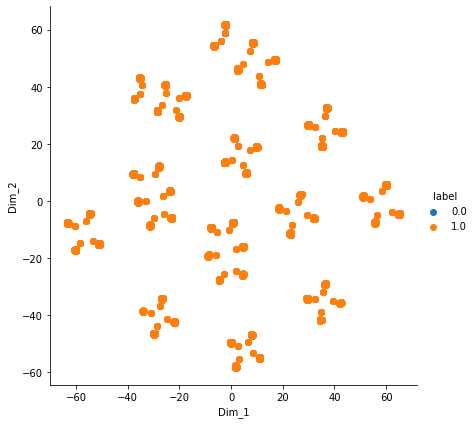

In [98]:
# TSNE
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, random_state = 0)
tsne_data = model.fit_transform(x)
 
# creating a new data frame which
# help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))
 
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue ="label", size = 6).map(
       plt.scatter, 'Dim_1', 'Dim_2').add_legend()
 
plt.show()

* Data not possibly classified by tsne.

<AxesSubplot:>

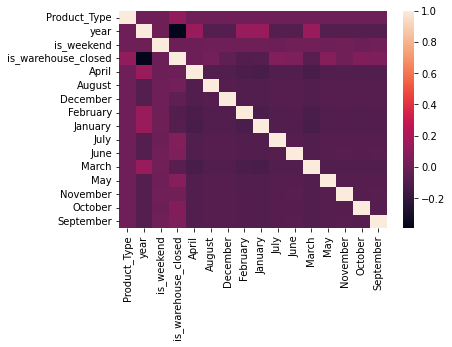

In [99]:
sns.heatmap(q.corr())

* We can remove either of year, is_warehouse_closed for reducing multicollinearity.

In [100]:
train_df['warehouse_ID'].unique()

array(['WH_0x3e9', 'WH_0x3ea', 'WH_0x3eb', 'WH_0x3ec', 'WH_0x3ed',
       'WH_0x3ee', 'WH_0x3ef', 'WH_0x3f1', 'WH_0x3f0', 'WH_0x3f2'],
      dtype=object)

c:\projects\digit_prediction\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


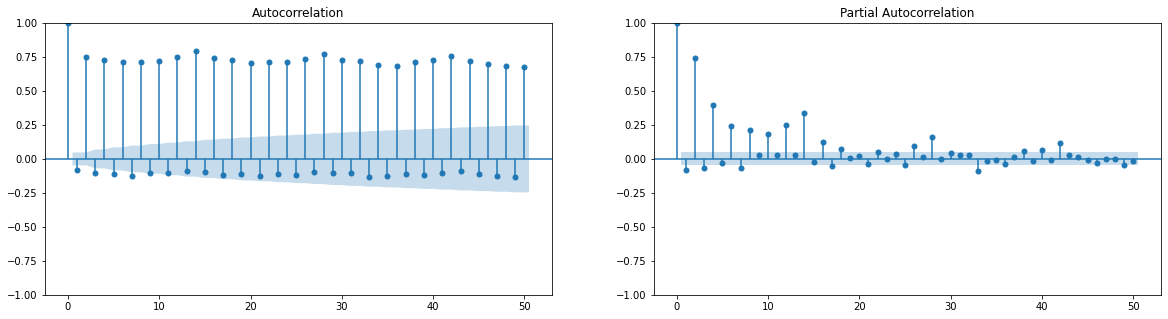

In [101]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))
q = train_df[train_df['warehouse_ID'] == 'WH_0x3e9']
plot_acf(q['daily_dispatch_count'], lags = 50,ax=ax1)
plot_pacf(q['daily_dispatch_count'],lags=50,ax=ax2)
plt.show()


c:\projects\digit_prediction\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


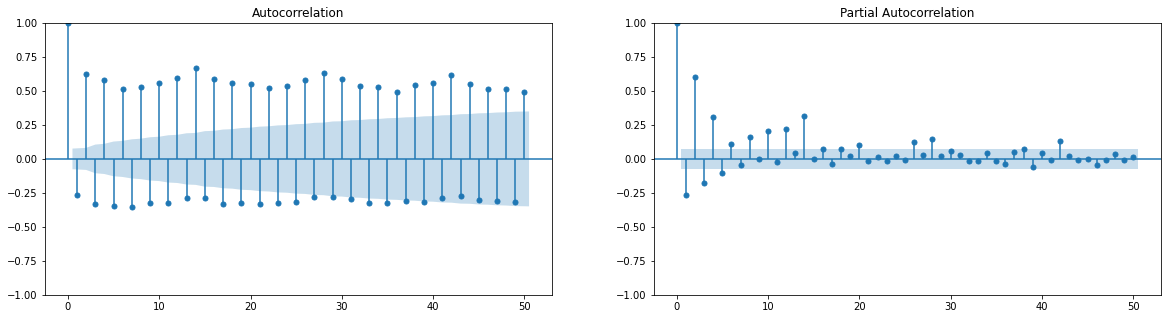

In [102]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))
q = train_df[train_df['warehouse_ID'] == 'WH_0x3f2']
plot_acf(q['daily_dispatch_count'], lags = 50,ax=ax1)
plot_pacf(q['daily_dispatch_count'],lags=50,ax=ax2)
plt.show()


* ACF shows the correlation coeffecient for the dispatch_count with past n data or lags with complete consideration of time series components.
* PACF explains the correlation coefficient for residuals.
* We can see partial auto coreelation in most of the series (warehouses) after 15 lags.
* For simplification, i will use 16 previous records for predicting the next dispatch value.


## data preprocessing

In [161]:
month = pd.get_dummies(train_df['month'])
train_df.drop(['month'], axis=1,inplace=True)
train_df = pd.concat([train_df,month], axis=1)
train_df.drop(['Latitude','Longitude','ID','year', 'is_weekend', ],axis=1,inplace=True)

## submission preprocessing

In [162]:
test_df = pd.read_csv(test_path)
print(test_df.shape)

(4900, 10)


In [163]:
test_df['is_warehouse_closed'] = test_df['is_warehouse_closed'].apply(lambda x: checkout(x))
test_df['is_weekend'] = test_df['is_weekend'].apply(lambda x: checkout(x))
test_df['Product_Type'] = test_df['Product_Type'].apply(lambda x: 1 if x=='Type_A' else 0)

In [164]:
crosstab = pd.crosstab(test_df['Product_Type'], test_df['is_weekend'])
stat, p, dof, expected = chi2_contingency(crosstab)
print('Degress of freedom = %d' % dof)
# print(expected)
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

if abs(stat) >= critical:
	print('Dependent (We reject H0)')
else:
	print('Independent (We fail to reject H0)')
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (We reject H0)')
else:
	print('Independent (We fail to reject H0)')
 
crosstab = pd.crosstab(test_df['Product_Type'], test_df['month'])
stat, p, dof, expected = chi2_contingency(crosstab)
print('Degress of freedom = %d' % dof)
# print(expected)
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

if abs(stat) >= critical:
	print('Dependent (We reject H0)')
else:
	print('Independent (We fail to reject H0)')
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (We reject H0)')
else:
	print('Independent (We fail to reject H0)')
test_df.drop(['Latitude','Longitude','ID','year'],axis=1,inplace=True)
month = pd.get_dummies(test_df['month'])
test_df.drop(['month'], axis=1,inplace=True)
test_df = pd.concat([test_df,month], axis=1)


Degress of freedom = 1
probability=0.950, critical=3.841, stat=0.023
Independent (We fail to reject H0)
significance=0.050, p=0.880
Independent (We fail to reject H0)
Degress of freedom = 7
probability=0.950, critical=14.067, stat=0.000
Independent (We fail to reject H0)
significance=0.050, p=1.000
Independent (We fail to reject H0)


## Model Training

* There are 10 unique warehouses, and 10 different models will be trained for warehouses respectively.
* LSTM will be used within neural networks, since they can help remebering the patterns of the data.
* By the partial auto correlation, i will use 16 previous records for predicting the next dispatch value.


## ware1 train (WH_0x3ea)

In [165]:
ware1 = train_df[train_df['warehouse_ID'] == 'WH_0x3ea'].drop(['warehouse_ID','date'],axis=1)
ware1.drop(['weekly_dispatch_count'],axis=1,inplace=True)
ware1 = ware1.drop(['is_warehouse_closed'],axis=1)
# ware1 = ware1[['Product_Type','daily_dispatch_count']]
n = len(ware1)
train_ware1 = ware1[0:int(n*0.90)]
val_ware1 = ware1[int(n*0.90):]
from sklearn.preprocessing import StandardScaler, StandardScaler,PowerTransformer,Normalizer
scaler = StandardScaler()
X = train_ware1.drop(['daily_dispatch_count'], axis=1)
y = train_ware1[['daily_dispatch_count']]
scaled_w1 = scaler.fit_transform(X)
y_scaler = StandardScaler()
scaled_y1  = y_scaler.fit_transform(y)
import numpy as np
trainX = []
trainY = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_w1) - n_future+1):
    trainX.append(scaled_w1[i - n_past: i,0:scaled_w1.shape[1]])
    trainY.append(scaled_y1[i + n_future - 1:i + n_future])
trainX, trainY = np.array(trainX), np.array(trainY)
valx = val_ware1.drop(['daily_dispatch_count'], axis=1)
valy = val_ware1[['daily_dispatch_count']]
scaled_valx = scaler.transform(valx)
scaled_valy = y_scaler.transform(valy)
import numpy as np
valX = []
valY = []
n_future = 1
n_past = 16

for i in range(n_past, len(scaled_valx) - n_future+1):
    valX.append(scaled_valx[i - n_past: i,0:scaled_valx.shape[1]])
    valY.append(scaled_valy[i + n_future - 1:i + n_future])
valX, valY = np.array(valX), np.array(valY)

model = Sequential()
# # model.add(LSTM(500, activation='tanh', input_shape=(15, 13), return_sequences=True))
# model.add(LSTM(250, activation='tanh', input_shape=(16, 13),return_sequences=True))
# # model.add(Dropout(0.2))
# model.add(LSTM(120, activation='tanh', return_sequences=False))
# model.add(Dense(60,activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='rmsprop', loss='mse',metrics='mse')
# model.summary()

model.add(Bidirectional(LSTM(800, activation='tanh', input_shape=(16, 13),return_sequences=False)))
# model.add(BatchNormalization())
# model.add(Bidirectional(LSTM(200, activation='tanh', return_sequences=False)))
model.add(Dropout(0.25))
# model.add(Dense(100,activation='relu'))
model.add(Dense(80,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics='mse')

In [108]:
history = model.fit(trainX,trainY, epochs=80, verbose=1 ,shuffle=False,validation_data=(valX,valY))
# 
ypred = model.predict(valX)
y_val = y_scaler.inverse_transform(valY.reshape(-1,1))  
ypred = y_scaler.inverse_transform(ypred.reshape(-1,1))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,ypred,squared=False))


Epoch 1/80
48/48 [==============================] - 67s 56ms/step - loss: 0.9448 - mse: 0.9448 - val_loss: 1.3146 - val_mse: 1.3146
Epoch 2/80
48/48 [==============================] - 1s 19ms/step - loss: 0.9097 - mse: 0.9097 - val_loss: 1.2326 - val_mse: 1.2326
Epoch 3/80
48/48 [==============================] - 1s 17ms/step - loss: 0.8589 - mse: 0.8589 - val_loss: 1.2398 - val_mse: 1.2398
Epoch 4/80
48/48 [==============================] - 1s 16ms/step - loss: 0.8302 - mse: 0.8302 - val_loss: 1.0876 - val_mse: 1.0876
Epoch 5/80
48/48 [==============================] - 1s 16ms/step - loss: 0.6028 - mse: 0.6028 - val_loss: 0.4790 - val_mse: 0.4790
Epoch 6/80
48/48 [==============================] - 1s 16ms/step - loss: 0.3002 - mse: 0.3002 - val_loss: 0.4995 - val_mse: 0.4995
Epoch 7/80
48/48 [==============================] - 1s 17ms/step - loss: 0.2396 - mse: 0.2396 - val_loss: 0.4962 - val_mse: 0.4962
Epoch 8/80
48/48 [==============================] - 1s 16ms/step - loss: 0.2458 - 

In [166]:

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,ypred,squared=False))

2.6741656904403697


*2.8 for minmax minmax 60epochs 
*2.7 fro standard minmax 80 epochs

In [110]:
# g = pd.DataFrame(ypred).describe()
# f = pd.DataFrame(y_val).describe()
# np.hstack([g,f])

In [ ]:
import os
model_path = 'warehouses/ware1/models/model.h5'
model1path = os.path.join(base_path,model_path)
model.save(model1path)

## ware 1 submission

In [112]:
print(test_df[test_df['warehouse_ID'] == 'WH_0x3ea'].shape)
# test_df[test_df['warehouse_ID'] == 'WH_0x3ea'].head()
ware1_test = test_df[test_df['warehouse_ID'] == 'WH_0x3ea'].drop(['warehouse_ID','date'],axis=1)
ware1testindex= ware1_test.index
ware1_test.drop([ 'is_weekend','is_warehouse_closed'],axis=1,inplace=True)
ware1_test[['April', 'February', 'January', 'March', 'daily_dispatch_count']] = 0
ware1_test = ware1_test[train_ware1.columns]
prev1 = train_df[train_df['warehouse_ID'] == 'WH_0x3ea'].tail(16).drop(['warehouse_ID','date','is_warehouse_closed','daily_dispatch_count','weekly_dispatch_count'],axis=1)
prev1['daily_dispatch_count'] = 0
prev1 = prev1[train_ware1.columns]
ware1_test = pd.concat([prev1,ware1_test],axis=0,)
x = ware1_test.drop(['daily_dispatch_count'], axis=1)
scaled_test1 = scaler.transform(x)
import numpy as np
testx1 = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_test1) - n_future+1):
    testx1.append(scaled_test1[i - n_past: i,0:scaled_test1.shape[1]])
testX1 = np.array(testx1)
model1 = load_model(model1path)

ware1_dispatch = y_scaler.inverse_transform(model1.predict(testX1))
len(ware1_dispatch)
sub1 = pd.DataFrame(data = {
    "daily_dispatch_count":ware1_dispatch.flatten(),
    "warehouse_ID": ['WH_0x3ea'] * len(ware1_dispatch),
    
},index= ware1testindex)
sub1.head()


(490, 13)


,daily_dispatch_count,warehouse_ID
2,6.707429,WH_0x3ea
3,2.350477,WH_0x3ea
22,6.508402,WH_0x3ea
23,2.040584,WH_0x3ea
42,6.224710,WH_0x3ea


In [113]:
pred_path = 'warehouses\ware1\preds\ware1.csv'
predpath1= os.path.join(base_path,pred_path)
sub1.to_csv(predpath1,index=True)

## ware2 train (WH_0x3eb)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 16, 250)           264000    
                                                                 
 lstm_7 (LSTM)               (None, 120)               178080    
                                                                 
 dense_6 (Dense)             (None, 60)                7260      
                                                                 
 dense_7 (Dense)             (None, 1)                 61        
                                                                 
Total params: 449,401
Trainable params: 449,401
Non-trainable params: 0
_________________________________________________________________


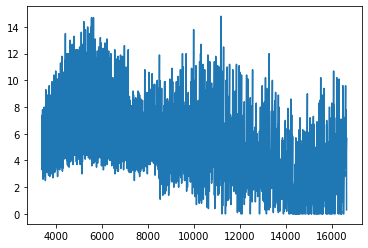

In [114]:
ware2 = train_df[train_df['warehouse_ID'] == 'WH_0x3eb'].drop(['warehouse_ID','date'],axis=1)
ware2.drop(['weekly_dispatch_count'],axis=1,inplace=True)
ware2 = ware2.drop(['is_warehouse_closed'],axis=1)
ware2['daily_dispatch_count'].plot()
n = len(ware2)
train_ware2 = ware2[0:int(n*0.90)]
val_ware2 = ware2[int(n*0.90):]
from sklearn.preprocessing import StandardScaler, StandardScaler
scaler2 = StandardScaler()
X = train_ware2.drop(['daily_dispatch_count'], axis=1)
y = train_ware2[['daily_dispatch_count']]
scaled_w2 = scaler2.fit_transform(X)
y_scaler2 = StandardScaler()
scaled_y2  = y_scaler2.fit_transform(y)
import numpy as np
trainX = []
trainY = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_w2) - n_future+1):
    trainX.append(scaled_w2[i - n_past: i,0:scaled_w2.shape[1]])
    trainY.append(scaled_y2[i + n_future - 1:i + n_future])
trainX, trainY = np.array(trainX), np.array(trainY)
valx = val_ware2.drop(['daily_dispatch_count'], axis=1)
valy = val_ware2[['daily_dispatch_count']]
scaled_valx = scaler2.transform(valx)
scaled_valy = y_scaler2.transform(valy)
import numpy as np
valX = []
valY = []
n_future = 1
n_past = 16

for i in range(n_past, len(scaled_valx) - n_future+1):
    valX.append(scaled_valx[i - n_past: i,0:scaled_valx.shape[1]])
    valY.append(scaled_valy[i + n_future - 1:i + n_future])
valX, valY = np.array(valX), np.array(valY)

# model = Sequential()
# model.add(Bidirectional(LSTM(800, activation='tanh', input_shape=(16, 13),return_sequences=False)))
# # model.add(BatchNormalization())
# # model.add(Bidirectional(LSTM(200, activation='tanh', return_sequences=False)))
# model.add(Dropout(0.25))
# # model.add(Dense(100,activation='relu'))
# model.add(Dense(60,activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='rmsprop', loss='mse',metrics='mse')


model = Sequential()
# model.add(LSTM(500, activation='tanh', input_shape=(15, 13), return_sequences=True))
model.add(LSTM(250, activation='tanh', input_shape=(16, 13),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(120, activation='tanh', return_sequences=False))
model.add(Dense(60,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics='mse')
model.summary()


In [115]:
history = model.fit(trainX,trainY, epochs=80, verbose=0,shuffle=False)
ypred = model.predict(valX)
y_val = y_scaler2.inverse_transform(valY.reshape(-1,1))
ypred = y_scaler2.inverse_transform(ypred.reshape(-1,1))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,ypred,squared=False))

2.219470444981455


* 2.7 for 85% 
* 2.9 for 90%
* 2.4 for prev

In [116]:
g = pd.DataFrame(ypred).describe()
f = pd.DataFrame(y_val).describe()
np.hstack([g,f])

array([[155.        , 155.        ],
       [  3.53420329,   3.28451613],
       [  2.2375133 ,   3.02659515],
       [  0.93131113,   0.        ],
       [  1.61282253,   0.45      ],
       [  1.78718805,   2.6       ],
       [  5.88254428,   5.65      ],
       [  6.40875387,  10.7       ]])

In [117]:
import os
model_path = 'warehouses/ware2/models/model.h5'
model2path = os.path.join(base_path,model_path)
model.save(model2path)

## ware 2 submission

In [118]:
print(test_df[test_df['warehouse_ID'] == 'WH_0x3eb'].shape)
test_df[test_df['warehouse_ID'] == 'WH_0x3eb'].head()
ware2_test = test_df[test_df['warehouse_ID'] == 'WH_0x3eb'].drop(['warehouse_ID','date'],axis=1)
ware2testindex= ware2_test.index
ware2_test.drop([ 'is_weekend','is_warehouse_closed'],axis=1,inplace=True)
ware2_test[['April', 'February', 'January', 'March', 'daily_dispatch_count']] = 0
ware2_test = ware2_test[train_ware2.columns]
prev2 = train_df[train_df['warehouse_ID'] == 'WH_0x3eb'].tail(16).drop(['warehouse_ID','date','is_warehouse_closed','daily_dispatch_count','weekly_dispatch_count'],axis=1)
prev2['daily_dispatch_count'] = 0
prev2 = prev2[train_ware2.columns]
ware2_test = pd.concat([prev2,ware2_test],axis=0,)
x = ware2_test.drop(['daily_dispatch_count'], axis=1)
scaled_test2 = scaler2.transform(x)
import numpy as np
testx2 = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_test2) - n_future+1):
    testx2.append(scaled_test2[i - n_past: i,0:scaled_test2.shape[1]])
testX2 = np.array(testx2)
model = load_model(model2path)
ware2_dispatch = y_scaler2.inverse_transform(model.predict(testX2))
len(ware2_dispatch)
sub2 = pd.DataFrame(data = {
    "daily_dispatch_count":ware2_dispatch.flatten(),
    "warehouse_ID": ['WH_0x3eb'] * len(ware2_dispatch),
    
},index= ware2testindex)
sub2.head()


(490, 13)


,daily_dispatch_count,warehouse_ID
4,6.408754,WH_0x3eb
5,1.807917,WH_0x3eb
24,6.456815,WH_0x3eb
25,1.786963,WH_0x3eb
44,6.558316,WH_0x3eb


In [119]:
pred_path = 'warehouses\ware2\preds\ware2.csv'
predpath2= os.path.join(base_path,pred_path)
sub2.to_csv(predpath2,index=True)

## ware3 train (WH_0x3ec)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 16, 250)           264000    
                                                                 
 lstm_9 (LSTM)               (None, 120)               178080    
                                                                 
 dense_8 (Dense)             (None, 60)                7260      
                                                                 
 dense_9 (Dense)             (None, 1)                 61        
                                                                 
Total params: 449,401
Trainable params: 449,401
Non-trainable params: 0
_________________________________________________________________


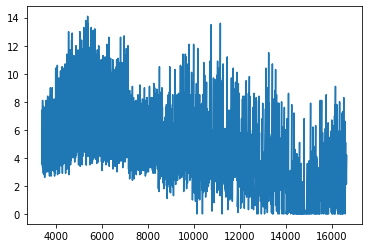

In [120]:
ware3 = train_df[train_df['warehouse_ID'] == 'WH_0x3ec'].drop(['warehouse_ID','date'],axis=1)
ware3.drop(['weekly_dispatch_count'],axis=1,inplace=True)
ware3 = ware3.drop(['is_warehouse_closed'],axis=1)
ware3['daily_dispatch_count'].plot()
n = len(ware3)
train_ware3 = ware3[0:int(n*0.90)]
val_ware3 = ware3[int(n*0.90):]
from sklearn.preprocessing import StandardScaler, StandardScaler
scaler3 = StandardScaler()
X = train_ware3.drop(['daily_dispatch_count'], axis=1)
y = train_ware3[['daily_dispatch_count']]
scaled_w3 = scaler3.fit_transform(X)
y_scaler3 = StandardScaler()
scaled_y3  = y_scaler3.fit_transform(y)
import numpy as np
trainX = []
trainY = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_w3) - n_future+1):
    trainX.append(scaled_w3[i - n_past: i,0:scaled_w3.shape[1]])
    trainY.append(scaled_y3[i + n_future - 1:i + n_future])
trainX, trainY = np.array(trainX), np.array(trainY)
valx = val_ware3.drop(['daily_dispatch_count'], axis=1)
valy = val_ware3[['daily_dispatch_count']]
scaled_valx = scaler3.transform(valx)
scaled_valy = y_scaler3.transform(valy)
import numpy as np
valX = []
valY = []
n_future = 1
n_past = 16

for i in range(n_past, len(scaled_valx) - n_future+1):
    valX.append(scaled_valx[i - n_past: i,0:scaled_valx.shape[1]])
    valY.append(scaled_valy[i + n_future - 1:i + n_future])
valX, valY = np.array(valX), np.array(valY)

model = Sequential()
# model.add(LSTM(500, activation='tanh', input_shape=(15, 13), return_sequences=True))
model.add(LSTM(250, activation='tanh', input_shape=(16, 13),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(120, activation='tanh', return_sequences=False))
model.add(Dense(60,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics='mse')
model.summary()

In [121]:
history = model.fit(trainX,trainY, epochs=80, verbose=1,shuffle=False)
ypred = model.predict(valX)
y_val = y_scaler3.inverse_transform(valY.reshape(-1,1))
ypred = y_scaler3.inverse_transform(ypred.reshape(-1,1))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,ypred,squared=False))

Epoch 1/80
48/48 [==============================] - 4s 14ms/step - loss: 0.9318 - mse: 0.9318
Epoch 2/80
48/48 [==============================] - 1s 12ms/step - loss: 1.0209 - mse: 1.0209
Epoch 3/80
48/48 [==============================] - 1s 11ms/step - loss: 0.9540 - mse: 0.9540
Epoch 4/80
48/48 [==============================] - 1s 11ms/step - loss: 0.9037 - mse: 0.9037
Epoch 5/80
48/48 [==============================] - 1s 11ms/step - loss: 0.9330 - mse: 0.9330
Epoch 6/80
48/48 [==============================] - 1s 11ms/step - loss: 0.8996 - mse: 0.8996
Epoch 7/80
48/48 [==============================] - 1s 11ms/step - loss: 0.6866 - mse: 0.6866
Epoch 8/80
48/48 [==============================] - 1s 11ms/step - loss: 0.4148 - mse: 0.4148
Epoch 9/80
48/48 [==============================] - 1s 11ms/step - loss: 0.4062 - mse: 0.4062
Epoch 10/80
48/48 [==============================] - 1s 11ms/step - loss: 0.4496 - mse: 0.4496
Epoch 11/80
48/48 [==============================] - 1s 11m

*2.2 before 
*2.28 for 100 epochs
*2.428 for 15
*2.4 for 80 epochs and 90%

In [122]:
import os
model_path = 'warehouses/ware3/models/model.h5'
model3path = os.path.join(base_path,model_path)
model.save(model3path)

## ware 3 submission

In [123]:
print(test_df[test_df['warehouse_ID'] == 'WH_0x3ec'].shape)
test_df[test_df['warehouse_ID'] == 'WH_0x3ec'].head()
ware3_test = test_df[test_df['warehouse_ID'] == 'WH_0x3ec'].drop(['warehouse_ID','date'],axis=1)
ware3testindex= ware3_test.index
ware3_test.drop([ 'is_weekend','is_warehouse_closed'],axis=1,inplace=True)
ware3_test[['April', 'February', 'January', 'March', 'daily_dispatch_count']] = 0
ware3_test = ware3_test[train_ware3.columns]
prev3 = train_df[train_df['warehouse_ID'] == 'WH_0x3ec'].tail(16).drop(['warehouse_ID','date','is_warehouse_closed','daily_dispatch_count','weekly_dispatch_count'],axis=1)
prev3['daily_dispatch_count'] = 0
prev3 = prev3[train_ware3.columns]
ware3_test = pd.concat([prev3,ware3_test],axis=0,)
x = ware3_test.drop(['daily_dispatch_count'], axis=1)
scaled_test3 = scaler3.transform(x)
import numpy as np
testx3 = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_test3) - n_future+1):
    testx3.append(scaled_test3[i - n_past: i,0:scaled_test3.shape[1]])
testX3 = np.array(testx3)
model = load_model(model3path)
ware3_dispatch = y_scaler3.inverse_transform(model.predict(testX3))
len(ware3_dispatch)
sub3 = pd.DataFrame(data = {
    "daily_dispatch_count":ware3_dispatch.flatten(),
    "warehouse_ID": ['WH_0x3ec'] * len(ware3_dispatch),
    
},index= ware3testindex)
sub3.head()
pred_path = 'warehouses\ware3\preds\ware3.csv'
predpath3= os.path.join(base_path,pred_path)
sub3.to_csv(predpath3,index=True)


(490, 13)


## ware4 train (WH_0x3ed)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 16, 250)           264000    
                                                                 
 lstm_11 (LSTM)              (None, 120)               178080    
                                                                 
 dense_10 (Dense)            (None, 60)                7260      
                                                                 
 dense_11 (Dense)            (None, 1)                 61        
                                                                 
Total params: 449,401
Trainable params: 449,401
Non-trainable params: 0
_________________________________________________________________
2.370619534049691


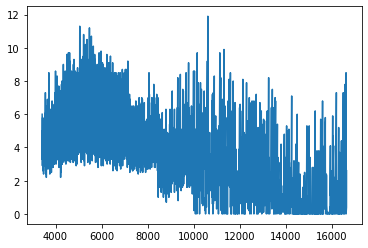

In [124]:
ware4 = train_df[train_df['warehouse_ID'] == 'WH_0x3ed'].drop(['warehouse_ID','date'],axis=1)
ware4.drop(['weekly_dispatch_count'],axis=1,inplace=True)
ware4 = ware4.drop(['is_warehouse_closed'],axis=1)
ware4['daily_dispatch_count'].plot()
n = len(ware4)
train_ware4 = ware4[0:int(n*0.90
)]
val_ware4 = ware4[int(n*0.90
):]
from sklearn.preprocessing import StandardScaler, StandardScaler
scaler4 = StandardScaler()
X = train_ware4.drop(['daily_dispatch_count'], axis=1)
y = train_ware4[['daily_dispatch_count']]
scaled_w4 = scaler4.fit_transform(X)
y_scaler4 = StandardScaler()
scaled_y4  = y_scaler4.fit_transform(y)
import numpy as np
trainX = []
trainY = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_w4) - n_future+1):
    trainX.append(scaled_w4[i - n_past: i,0:scaled_w4.shape[1]])
    trainY.append(scaled_y4[i + n_future - 1:i + n_future])
trainX, trainY = np.array(trainX), np.array(trainY)
valx = val_ware4.drop(['daily_dispatch_count'], axis=1)
valy = val_ware4[['daily_dispatch_count']]
scaled_valx = scaler4.transform(valx)
scaled_valy = y_scaler4.transform(valy)
import numpy as np
valX = []
valY = []
n_future = 1
n_past = 16

for i in range(n_past, len(scaled_valx) - n_future+1):
    valX.append(scaled_valx[i - n_past: i,0:scaled_valx.shape[1]])
    valY.append(scaled_valy[i + n_future - 1:i + n_future])
valX, valY = np.array(valX), np.array(valY)

model = Sequential()
# model.add(LSTM(500, activation='tanh', input_shape=(15, 13), return_sequences=True))
model.add(LSTM(250, activation='tanh', input_shape=(16, 13),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(120, activation='tanh', return_sequences=False))
model.add(Dense(60,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics='mse')
model.summary()

history = model.fit(trainX,trainY, epochs=80, verbose=0,shuffle=False)
ypred = model.predict(valX)
y_val = y_scaler4.inverse_transform(valY.reshape(-1,1))
ypred = y_scaler4.inverse_transform(ypred.reshape(-1,1))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,ypred,squared=False))

In [125]:
import os
model_path = 'warehouses/ware4/models/model.h5'
model4path = os.path.join(base_path,model_path)
model.save(model4path)

## ware 4 submission

In [126]:
print(test_df[test_df['warehouse_ID'] == 'WH_0x3ed'].shape)
test_df[test_df['warehouse_ID'] == 'WH_0x3ed'].head()
ware4_test = test_df[test_df['warehouse_ID'] == 'WH_0x3ed'].drop(['warehouse_ID','date'],axis=1)
ware4testindex= ware4_test.index
ware4_test.drop([ 'is_weekend','is_warehouse_closed'],axis=1,inplace=True)
ware4_test[['April', 'February', 'January', 'March', 'daily_dispatch_count']] = 0
ware4_test = ware4_test[train_ware4.columns]
prev4 = train_df[train_df['warehouse_ID'] == 'WH_0x3ed'].tail(15).drop(['warehouse_ID','date','is_warehouse_closed','daily_dispatch_count','weekly_dispatch_count'],axis=1)
prev4['daily_dispatch_count'] = 0
prev4 = prev4[train_ware4.columns]
ware3_test = pd.concat([prev4,ware4_test],axis=0,)
x = ware4_test.drop(['daily_dispatch_count'], axis=1)
scaled_test4 = scaler4.transform(x)
import numpy as np
testx4 = []
n_future = 1
n_past = 15
for i in range(n_past, len(scaled_test4) - n_future+1):
    testx4.append(scaled_test4[i - n_past: i,0:scaled_test4.shape[1]])
testX4 = np.array(testx4)
model = load_model(model4path)
ware4_dispatch = y_scaler4.inverse_transform(model.predict(testX3))
len(ware4_dispatch)
sub4 = pd.DataFrame(data = {
    "daily_dispatch_count":ware4_dispatch.flatten(),
    "warehouse_ID": ['WH_0x3ed'] * len(ware4_dispatch),
    
},index= ware4testindex)
sub4.head()
pred_path = 'warehouses\ware4\preds\ware4.csv'
predpath4= os.path.join(base_path,pred_path)
sub4.to_csv(predpath4,index=True)

(490, 13)


# ware5 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 16, 250)           264000    
                                                                 
 lstm_13 (LSTM)              (None, 120)               178080    
                                                                 
 dense_12 (Dense)            (None, 60)                7260      
                                                                 
 dense_13 (Dense)            (None, 1)                 61        
                                                                 
Total params: 449,401
Trainable params: 449,401
Non-trainable params: 0
_________________________________________________________________
3.196602996930644
(490, 13)


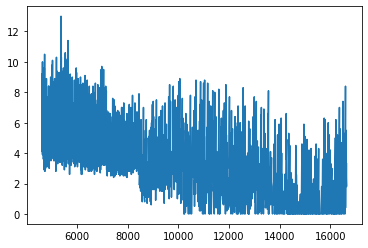

In [127]:
## ware5 train (WH_0x3ee)
ware5 = train_df[train_df['warehouse_ID'] == 'WH_0x3ee'].drop(['warehouse_ID','date'],axis=1)
ware5.drop(['weekly_dispatch_count'],axis=1,inplace=True)
ware5 = ware5.drop(['is_warehouse_closed'],axis=1)
ware5['daily_dispatch_count'].plot()
n = len(ware5)
train_ware5 = ware5[0:int(n*0.90)]
val_ware5 = ware5[int(n*0.90):]

from sklearn.preprocessing import StandardScaler, StandardScaler
scaler5 = StandardScaler()
X = train_ware5.drop(['daily_dispatch_count'], axis=1)
y = train_ware5[['daily_dispatch_count']]
scaled_w5 = scaler5.fit_transform(X)
y_scaler5 = StandardScaler()
scaled_y5  = y_scaler5.fit_transform(y)
import numpy as np
trainX = []
trainY = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_w5) - n_future+1):
    trainX.append(scaled_w5[i - n_past: i,0:scaled_w5.shape[1]])
    trainY.append(scaled_y5[i + n_future - 1:i + n_future])
trainX, trainY = np.array(trainX), np.array(trainY)
valx = val_ware5.drop(['daily_dispatch_count'], axis=1)
valy = val_ware5[['daily_dispatch_count']]
scaled_valx = scaler5.transform(valx)
scaled_valy = y_scaler5.transform(valy)
import numpy as np
valX = []
valY = []
n_future = 1
n_past = 16

for i in range(n_past, len(scaled_valx) - n_future+1):
    valX.append(scaled_valx[i - n_past: i,0:scaled_valx.shape[1]])
    valY.append(scaled_valy[i + n_future - 1:i + n_future])
valX, valY = np.array(valX), np.array(valY)

model = Sequential()
# model.add(LSTM(500, activation='tanh', input_shape=(15, 13), return_sequences=True))
model.add(LSTM(250, activation='tanh', input_shape=(16, 13),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(120, activation='tanh', return_sequences=False))
model.add(Dense(60,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics='mse')
model.summary()

ypred = model.predict(valX)
y_val = y_scaler5.inverse_transform(valY.reshape(-1,1))
ypred = y_scaler5.inverse_transform(ypred.reshape(-1,1))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,ypred,squared=False))
g = pd.DataFrame(ypred).describe()
f = pd.DataFrame(y_val).describe()
np.hstack([g,f])

import os
model_path = 'warehouses/ware5/models/model.h5'
model5path = os.path.join(base_path,model_path)
model.save(model5path)

## ware 3 submission
print(test_df[test_df['warehouse_ID'] == 'WH_0x3ee'].shape)
test_df[test_df['warehouse_ID'] == 'WH_0x3ee'].head()
ware5_test = test_df[test_df['warehouse_ID'] == 'WH_0x3ee'].drop(['warehouse_ID','date'],axis=1)
ware5testindex= ware5_test.index
ware5_test.drop([ 'is_weekend','is_warehouse_closed'],axis=1,inplace=True)
ware5_test[['April', 'February', 'January', 'March', 'daily_dispatch_count']] = 0
ware5_test = ware5_test[train_ware5.columns]

prev5 = train_df[train_df['warehouse_ID'] == 'WH_0x3ee'].tail(16).drop(['warehouse_ID','date','is_warehouse_closed','daily_dispatch_count','weekly_dispatch_count'],axis=1)
prev5['daily_dispatch_count'] = 0
prev5 = prev5[train_ware5.columns]
ware5_test = pd.concat([prev5,ware5_test],axis=0,)
x = ware5_test.drop(['daily_dispatch_count'], axis=1)
scaled_test5 = scaler5.transform(x)
import numpy as np
testx5 = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_test5) - n_future+1):
    testx5.append(scaled_test5[i - n_past: i,0:scaled_test5.shape[1]])
testX5 = np.array(testx5)
model = load_model(model5path)
ware5_dispatch = y_scaler5.inverse_transform(model.predict(testX5))
len(ware5_dispatch)
sub5 = pd.DataFrame(data = {
    "daily_dispatch_count":ware5_dispatch.flatten(),
    "warehouse_ID": ['WH_0x3ee'] * len(ware5_dispatch),
    
},index= ware5testindex)
sub5.head()
pred_path = 'warehouses\ware5\preds\ware5.csv'
predpath5= os.path.join(base_path,pred_path)
sub5.to_csv(predpath5,index=True)

# ware6

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 16, 250)           264000    
                                                                 
 lstm_15 (LSTM)              (None, 120)               178080    
                                                                 
 dense_14 (Dense)            (None, 60)                7260      
                                                                 
 dense_15 (Dense)            (None, 1)                 61        
                                                                 
Total params: 449,401
Trainable params: 449,401
Non-trainable params: 0
_________________________________________________________________
1.9914771819046446
(490, 13)


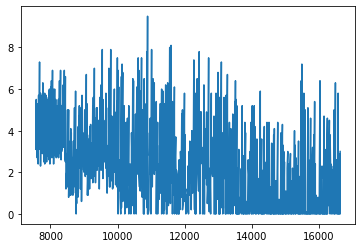

In [128]:
## ware6 train (WH_0x3ef)
ware6 = train_df[train_df['warehouse_ID'] == 'WH_0x3ef'].drop(['warehouse_ID','date'],axis=1)
ware6.drop(['weekly_dispatch_count'],axis=1,inplace=True)
ware6 = ware6.drop(['is_warehouse_closed'],axis=1)
ware6['daily_dispatch_count'].plot()
n = len(ware6)
train_ware6 = ware6[0:int(n*0.90)]
val_ware6 = ware6[int(n*0.90):]

from sklearn.preprocessing import StandardScaler, StandardScaler
scaler6 = StandardScaler()
X = train_ware6.drop(['daily_dispatch_count'], axis=1)
y = train_ware6[['daily_dispatch_count']]
scaled_w6 = scaler6.fit_transform(X)
y_scaler6 = StandardScaler()
scaled_y5  = y_scaler6.fit_transform(y)
import numpy as np
trainX = []
trainY = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_w6) - n_future+1):
    trainX.append(scaled_w6[i - n_past: i,0:scaled_w6.shape[1]])
    trainY.append(scaled_y5[i + n_future - 1:i + n_future])
trainX, trainY = np.array(trainX), np.array(trainY)
valx = val_ware6.drop(['daily_dispatch_count'], axis=1)
valy = val_ware6[['daily_dispatch_count']]
scaled_valx = scaler6.transform(valx)
scaled_valy = y_scaler6.transform(valy)
import numpy as np
valX = []
valY = []
n_future = 1
n_past = 16

for i in range(n_past, len(scaled_valx) - n_future+1):
    valX.append(scaled_valx[i - n_past: i,0:scaled_valx.shape[1]])
    valY.append(scaled_valy[i + n_future - 1:i + n_future])
valX, valY = np.array(valX), np.array(valY)
model = Sequential()
# model.add(LSTM(500, activation='tanh', input_shape=(15, 13), return_sequences=True))
model.add(LSTM(250, activation='tanh', input_shape=(16, 13),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(120, activation='tanh', return_sequences=False))
model.add(Dense(60,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics='mse')
model.summary()

ypred = model.predict(valX)
y_val = y_scaler6.inverse_transform(valY.reshape(-1,1))
ypred = y_scaler6.inverse_transform(ypred.reshape(-1,1))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,ypred,squared=False))
g = pd.DataFrame(ypred).describe()
f = pd.DataFrame(y_val).describe()
np.hstack([g,f])
import os
model_path = 'warehouses/ware6/models/model.h5'
model6path = os.path.join(base_path,model_path)
model.save(model6path)
## ware 3 submission
print(test_df[test_df['warehouse_ID'] == 'WH_0x3ef'].shape)
test_df[test_df['warehouse_ID'] == 'WH_0x3ef'].head()
ware6_test = test_df[test_df['warehouse_ID'] == 'WH_0x3ef'].drop(['warehouse_ID','date'],axis=1)
ware6testindex= ware6_test.index
ware6_test.drop([ 'is_weekend','is_warehouse_closed'],axis=1,inplace=True)
ware6_test[['April', 'February', 'January', 'March', 'daily_dispatch_count']] = 0
ware6_test = ware6_test[train_ware6.columns]

prev6 = train_df[train_df['warehouse_ID'] == 'WH_0x3ef'].tail(16).drop(['warehouse_ID','date','is_warehouse_closed','daily_dispatch_count','weekly_dispatch_count'],axis=1)
prev6['daily_dispatch_count'] = 0
prev6 = prev6[train_ware6.columns]
ware6_test = pd.concat([prev6,ware6_test],axis=0,)
x = ware6_test.drop(['daily_dispatch_count'], axis=1)
scaled_test6 = scaler6.transform(x)
import numpy as np
testx6 = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_test6) - n_future+1):
    testx6.append(scaled_test6[i - n_past: i,0:scaled_test6.shape[1]])
testX6 = np.array(testx6)
model = load_model(model6path)
ware6_dispatch = y_scaler6.inverse_transform(model.predict(testX6))
len(ware6_dispatch)
sub6 = pd.DataFrame(data = {
    "daily_dispatch_count":ware6_dispatch.flatten(),
    "warehouse_ID": ['WH_0x3ef'] * len(ware6_dispatch),
    
},index= ware6testindex)
sub6.head()
pred_path = 'warehouses\ware6\preds\ware6.csv'
predpath6= os.path.join(base_path,pred_path)
sub6.to_csv(predpath6,index=True)

# ware 7

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 16, 250)           264000    
                                                                 
 lstm_17 (LSTM)              (None, 120)               178080    
                                                                 
 dense_16 (Dense)            (None, 60)                7260      
                                                                 
 dense_17 (Dense)            (None, 1)                 61        
                                                                 
Total params: 449,401
Trainable params: 449,401
Non-trainable params: 0
_________________________________________________________________
3.1781461543450664
(490, 13)


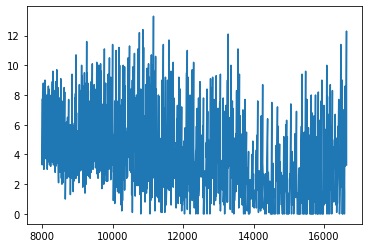

In [129]:
## ware7 train (WH_0x3f1)
ware7 = train_df[train_df['warehouse_ID'] == 'WH_0x3f1'].drop(['warehouse_ID','date'],axis=1)
ware7.drop(['weekly_dispatch_count'],axis=1,inplace=True)
ware7 = ware7.drop(['is_warehouse_closed'],axis=1)
ware7['daily_dispatch_count'].plot()
n = len(ware7)
train_ware7 = ware7[0:int(n*0.90)]  
val_ware7 = ware7[int(n*0.90):]

from sklearn.preprocessing import StandardScaler, StandardScaler
scaler7 = StandardScaler()
X = train_ware7.drop(['daily_dispatch_count'], axis=1)
y = train_ware7[['daily_dispatch_count']]
scaled_w7 = scaler7.fit_transform(X)
y_scaler7 = StandardScaler()
scaled_y5  = y_scaler7.fit_transform(y)
import numpy as np
trainX = []
trainY = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_w7) - n_future+1):
    trainX.append(scaled_w7[i - n_past: i,0:scaled_w7.shape[1]])
    trainY.append(scaled_y5[i + n_future - 1:i + n_future])
trainX, trainY = np.array(trainX), np.array(trainY)
valx = val_ware7.drop(['daily_dispatch_count'], axis=1)
valy = val_ware7[['daily_dispatch_count']]
scaled_valx = scaler7.transform(valx)
scaled_valy = y_scaler7.transform(valy)
import numpy as np
valX = []
valY = []
n_future = 1
n_past = 16

for i in range(n_past, len(scaled_valx) - n_future+1):
    valX.append(scaled_valx[i - n_past: i,0:scaled_valx.shape[1]])
    valY.append(scaled_valy[i + n_future - 1:i + n_future])
valX, valY = np.array(valX), np.array(valY)
model = Sequential()
# model.add(LSTM(500, activation='tanh', input_shape=(15, 13), return_sequences=True))
model.add(LSTM(250, activation='tanh', input_shape=(16, 13),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(120, activation='tanh', return_sequences=False))
model.add(Dense(60,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics='mse')
model.summary()

ypred = model.predict(valX)
y_val = y_scaler7.inverse_transform(valY.reshape(-1,1))
ypred = y_scaler7.inverse_transform(ypred.reshape(-1,1))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,ypred,squared=False))
g = pd.DataFrame(ypred).describe()
f = pd.DataFrame(y_val).describe()
np.hstack([g,f])
import os
model_path = 'warehouses/ware7/models/model.h5'
model7path = os.path.join(base_path,model_path)
model.save(model7path)
## ware 3 submission
print(test_df[test_df['warehouse_ID'] == 'WH_0x3f1'].shape)
test_df[test_df['warehouse_ID'] == 'WH_0x3f1'].head()
ware7_test = test_df[test_df['warehouse_ID'] == 'WH_0x3f1'].drop(['warehouse_ID','date'],axis=1)
ware7testindex= ware7_test.index
ware7_test.drop([ 'is_weekend','is_warehouse_closed'],axis=1,inplace=True)
ware7_test[['April', 'February', 'January', 'March', 'daily_dispatch_count']] = 0
ware7_test = ware7_test[train_ware7.columns]

prev7 = train_df[train_df['warehouse_ID'] == 'WH_0x3f1'].tail(16).drop(['warehouse_ID','date','is_warehouse_closed','daily_dispatch_count','weekly_dispatch_count'],axis=1)
prev7['daily_dispatch_count'] = 0
prev7 = prev7[train_ware7.columns]
ware7_test = pd.concat([prev7,ware7_test],axis=0,)
x = ware7_test.drop(['daily_dispatch_count'], axis=1)
scaled_test7 = scaler7.transform(x)
import numpy as np
testx7 = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_test7) - n_future+1):
    testx7.append(scaled_test7[i - n_past: i,0:scaled_test7.shape[1]])
testX7 = np.array(testx7)
model = load_model(model7path)
ware7_dispatch = y_scaler7.inverse_transform(model.predict(testX7))
len(ware7_dispatch)
sub7 = pd.DataFrame(data = {
    "daily_dispatch_count":ware7_dispatch.flatten(),
    "warehouse_ID": ['WH_0x3f1'] * len(ware7_dispatch),
    
},index= ware7testindex)
sub7.head()
pred_path = 'warehouses\ware7\preds\ware7.csv'
predpath7= os.path.join(base_path,pred_path)
sub7.to_csv(predpath7,index=True)

# ware 8

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 16, 250)           264000    
                                                                 
 lstm_19 (LSTM)              (None, 120)               178080    
                                                                 
 dense_18 (Dense)            (None, 60)                7260      
                                                                 
 dense_19 (Dense)            (None, 1)                 61        
                                                                 
Total params: 449,401
Trainable params: 449,401
Non-trainable params: 0
_________________________________________________________________
3.4122032462384744
(490, 13)


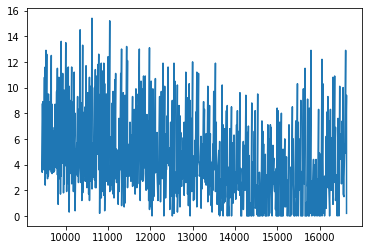

In [130]:
## ware8 train (WH_0x3f0)
ware8 = train_df[train_df['warehouse_ID'] == 'WH_0x3f0'].drop(['warehouse_ID','date'],axis=1)
ware8.drop(['weekly_dispatch_count'],axis=1,inplace=True)
ware8 = ware8.drop(['is_warehouse_closed'],axis=1)
ware8['daily_dispatch_count'].plot()
n = len(ware8)
train_ware8 = ware8[0:int(n*0.90)]
val_ware8 = ware8[int(n*0.90):]

from sklearn.preprocessing import StandardScaler, StandardScaler
scaler8 = StandardScaler()
X = train_ware8.drop(['daily_dispatch_count'], axis=1)
y = train_ware8[['daily_dispatch_count']]
scaled_w8 = scaler8.fit_transform(X)
y_scaler8 = StandardScaler()
scaled_y8  = y_scaler8.fit_transform(y)
import numpy as np
trainX = []
trainY = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_w8) - n_future+1):
    trainX.append(scaled_w8[i - n_past: i,0:scaled_w8.shape[1]])
    trainY.append(scaled_y8[i + n_future - 1:i + n_future])
trainX, trainY = np.array(trainX), np.array(trainY)
valx = val_ware8.drop(['daily_dispatch_count'], axis=1)
valy = val_ware8[['daily_dispatch_count']]
scaled_valx = scaler8.transform(valx)
scaled_valy = y_scaler8.transform(valy)
import numpy as np
valX = []
valY = []
n_future = 1
n_past = 16

for i in range(n_past, len(scaled_valx) - n_future+1):
    valX.append(scaled_valx[i - n_past: i,0:scaled_valx.shape[1]])
    valY.append(scaled_valy[i + n_future - 1:i + n_future])
valX, valY = np.array(valX), np.array(valY)
model = Sequential()
# model.add(LSTM(500, activation='tanh', input_shape=(15, 13), return_sequences=True))
model.add(LSTM(250, activation='tanh', input_shape=(16, 13),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(120, activation='tanh', return_sequences=False))
model.add(Dense(60,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics='mse')
model.summary()

ypred = model.predict(valX)
y_val = y_scaler8.inverse_transform(valY.reshape(-1,1))
ypred = y_scaler8.inverse_transform(ypred.reshape(-1,1))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,ypred,squared=False))
g = pd.DataFrame(ypred).describe()
f = pd.DataFrame(y_val).describe()
np.hstack([g,f])
model_path = 'warehouses/ware8/models/model.h5'
model8path = os.path.join(base_path,model_path)
model.save(model8path)
## ware 3 submission
print(test_df[test_df['warehouse_ID'] == 'WH_0x3f0'].shape)
test_df[test_df['warehouse_ID'] == 'WH_0x3f0'].head()
ware8_test = test_df[test_df['warehouse_ID'] == 'WH_0x3f0'].drop(['warehouse_ID','date'],axis=1)
ware8testindex= ware8_test.index
ware8_test.drop([ 'is_weekend','is_warehouse_closed'],axis=1,inplace=True)
ware8_test[['April', 'February', 'January', 'March', 'daily_dispatch_count']] = 0
ware8_test = ware8_test[train_ware8.columns]

prev8 = train_df[train_df['warehouse_ID'] == 'WH_0x3f0'].tail(16).drop(['warehouse_ID','date','is_warehouse_closed','daily_dispatch_count','weekly_dispatch_count'],axis=1)
prev8['daily_dispatch_count'] = 0
prev8 = prev8[train_ware8.columns]
ware8_test = pd.concat([prev8,ware8_test],axis=0,)
x = ware8_test.drop(['daily_dispatch_count'], axis=1)
scaled_test8 = scaler8.transform(x)
import numpy as np
testx8 = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_test8) - n_future+1):
    testx8.append(scaled_test8[i - n_past: i,0:scaled_test8.shape[1]])
testX8 = np.array(testx8)
model = load_model(model8path)
ware8_dispatch = y_scaler8.inverse_transform(model.predict(testX8))
len(ware8_dispatch)
sub8 = pd.DataFrame(data = {
    "daily_dispatch_count":ware8_dispatch.flatten(),
    "warehouse_ID": ['WH_0x3f0'] * len(ware8_dispatch),
    
},index= ware8testindex)
sub8.head()
pred_path = 'warehouses\ware8\preds\ware8.csv'
predpath8= os.path.join(base_path,pred_path)
sub8.to_csv(predpath8,index=True)

# ware 9

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 16, 250)           264000    
                                                                 
 lstm_21 (LSTM)              (None, 120)               178080    
                                                                 
 dense_20 (Dense)            (None, 60)                7260      
                                                                 
 dense_21 (Dense)            (None, 1)                 61        
                                                                 
Total params: 449,401
Trainable params: 449,401
Non-trainable params: 0
_________________________________________________________________
2.537298140399346
(490, 13)


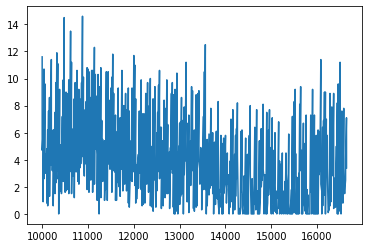

In [131]:
## ware9 train (WH_0x3f2)
ware9 = train_df[train_df['warehouse_ID'] == 'WH_0x3f2'].drop(['warehouse_ID','date'],axis=1)
ware9.drop(['weekly_dispatch_count'],axis=1,inplace=True)
ware9 = ware9.drop(['is_warehouse_closed'],axis=1)
ware9['daily_dispatch_count'].plot()
n = len(ware9)
train_ware9 = ware9[0:int(n*0.90)]
val_ware9 = ware9[int(n*0.90):]

from sklearn.preprocessing import StandardScaler, StandardScaler
scaler9 = StandardScaler()
X = train_ware9.drop(['daily_dispatch_count'], axis=1)
y = train_ware9[['daily_dispatch_count']]
scaled_w9 = scaler9.fit_transform(X)
y_scaler9 = StandardScaler()
scaled_y9  = y_scaler9.fit_transform(y)
import numpy as np
trainX = []
trainY = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_w9) - n_future+1):
    trainX.append(scaled_w9[i - n_past: i,0:scaled_w9.shape[1]])
    trainY.append(scaled_y9[i + n_future - 1:i + n_future])
trainX, trainY = np.array(trainX), np.array(trainY)
valx = val_ware9.drop(['daily_dispatch_count'], axis=1)
valy = val_ware9[['daily_dispatch_count']]
scaled_valx = scaler9.transform(valx)
scaled_valy = y_scaler9.transform(valy)
import numpy as np
valX = []
valY = []
n_future = 1
n_past = 16

for i in range(n_past, len(scaled_valx) - n_future+1):
    valX.append(scaled_valx[i - n_past: i,0:scaled_valx.shape[1]])
    valY.append(scaled_valy[i + n_future - 1:i + n_future])
valX, valY = np.array(valX), np.array(valY)

model = Sequential()
# model.add(LSTM(500, activation='tanh', input_shape=(15, 13), return_sequences=True))
model.add(LSTM(250, activation='tanh', input_shape=(16, 13),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(120, activation='tanh', return_sequences=False))
model.add(Dense(60,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics='mse')
model.summary()
history = model.fit(trainX,trainY, epochs=80, verbose=0,shuffle=False)

ypred = model.predict(valX)
y_val = y_scaler9.inverse_transform(valY.reshape(-1,1))
ypred = y_scaler9.inverse_transform(ypred.reshape(-1,1))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,ypred,squared=False))
g = pd.DataFrame(ypred).describe()
f = pd.DataFrame(y_val).describe()
np.hstack([g,f])
import os
model_path = 'warehouses/ware9/models/model.h5'
model9path = os.path.join(base_path,model_path)
model.save(model9path)
## ware 3 submission
print(test_df[test_df['warehouse_ID'] == 'WH_0x3f2'].shape)
test_df[test_df['warehouse_ID'] == 'WH_0x3f2'].head()
ware9_test = test_df[test_df['warehouse_ID'] == 'WH_0x3f2'].drop(['warehouse_ID','date'],axis=1)
ware9testindex= ware9_test.index
ware9_test.drop([ 'is_weekend','is_warehouse_closed'],axis=1,inplace=True)
ware9_test[['April', 'February', 'January', 'March', 'daily_dispatch_count']] = 0
ware9_test = ware9_test[train_ware9.columns]

prev9 = train_df[train_df['warehouse_ID'] == 'WH_0x3f2'].tail(16).drop(['warehouse_ID','date','is_warehouse_closed','daily_dispatch_count','weekly_dispatch_count'],axis=1)
prev9['daily_dispatch_count'] = 0
prev9 = prev9[train_ware9.columns]
ware9_test = pd.concat([prev9,ware9_test],axis=0,)
x = ware9_test.drop(['daily_dispatch_count'], axis=1)
scaled_test9 = scaler9.transform(x)
import numpy as np
testx9 = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_test9) - n_future+1):
    testx9.append(scaled_test9[i - n_past: i,0:scaled_test9.shape[1]])
testX9 = np.array(testx9)
model = load_model(model9path)
ware9_dispatch = y_scaler9.inverse_transform(model.predict(testX9))
len(ware9_dispatch)
sub9 = pd.DataFrame(data = {
    "daily_dispatch_count":ware9_dispatch.flatten(),
    "warehouse_ID": ['WH_0x3f2'] * len(ware9_dispatch),
    
},index= ware9testindex)
sub9.head()
pred_path = 'warehouses\ware9\preds\ware9.csv'
predpath9= os.path.join(base_path,pred_path)
sub9.to_csv(predpath9,index=True)

# ware 10

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 16, 250)           264000    
                                                                 
 lstm_23 (LSTM)              (None, 120)               178080    
                                                                 
 dense_22 (Dense)            (None, 60)                7260      
                                                                 
 dense_23 (Dense)            (None, 1)                 61        
                                                                 
Total params: 449,401
Trainable params: 449,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
48/48 [==============================] - 3s 12ms/step - loss: 0.9756 - mse: 0.9756
Epoch 2/80
48/48 [==============================] - 1s 11ms/step - loss: 0.9392 - mse

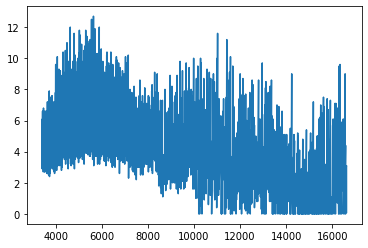

In [132]:
## ware10 train (WH_0x3e9)
ware10 = train_df[train_df['warehouse_ID'] == 'WH_0x3e9'].drop(['warehouse_ID','date'],axis=1)
ware10.drop(['weekly_dispatch_count'],axis=1,inplace=True)
ware10 = ware10.drop(['is_warehouse_closed'],axis=1)
ware10['daily_dispatch_count'].plot()
n = len(ware10)
train_ware10 = ware10[0:int(n*0.90)]
val_ware10 = ware10[int(n*0.90):]

from sklearn.preprocessing import StandardScaler, StandardScaler
scaler10 = StandardScaler()
X = train_ware10.drop(['daily_dispatch_count'], axis=1)
y = train_ware10[['daily_dispatch_count']]
scaled_w10 = scaler10.fit_transform(X)
y_scaler10 = StandardScaler()
scaled_y10  = y_scaler10.fit_transform(y)
import numpy as np
trainX = []
trainY = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_w10) - n_future+1):
    trainX.append(scaled_w10[i - n_past: i,0:scaled_w10.shape[1]])
    trainY.append(scaled_y10[i + n_future - 1:i + n_future])
trainX, trainY = np.array(trainX), np.array(trainY)
valx = val_ware10.drop(['daily_dispatch_count'], axis=1)
valy = val_ware10[['daily_dispatch_count']]
scaled_valx = scaler10.transform(valx)
scaled_valy = y_scaler10.transform(valy)
import numpy as np
valX = []
valY = []
n_future = 1
n_past = 16

for i in range(n_past, len(scaled_valx) - n_future+1):
    valX.append(scaled_valx[i - n_past: i,0:scaled_valx.shape[1]])
    valY.append(scaled_valy[i + n_future - 1:i + n_future])
valX, valY = np.array(valX), np.array(valY)

model = Sequential()
# model.add(LSTM(500, activation='tanh', input_shape=(15, 13), return_sequences=True))
model.add(LSTM(250, activation='tanh', input_shape=(16, 13),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(120, activation='tanh', return_sequences=False))
model.add(Dense(60,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics='mse')
model.summary()
history = model.fit(trainX,trainY, epochs=80, verbose=1,shuffle=False)

ypred = model.predict(valX)
y_val = y_scaler10.inverse_transform(valY.reshape(-1,1))
ypred = y_scaler10.inverse_transform(ypred.reshape(-1,1))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,ypred,squared=False))
g = pd.DataFrame(ypred).describe()
f = pd.DataFrame(y_val).describe()
np.hstack([g,f])

import os
model_path = 'warehouses/ware10/models/model.h5'
model10path = os.path.join(base_path,model_path)
model.save(model10path)

## ware 3 submission
print(test_df[test_df['warehouse_ID'] == 'WH_0x3e9'].shape)
test_df[test_df['warehouse_ID'] == 'WH_0x3e9'].head()
ware10_test = test_df[test_df['warehouse_ID'] == 'WH_0x3e9'].drop(['warehouse_ID','date'],axis=1)
ware10testindex= ware10_test.index
ware10_test.drop([ 'is_weekend','is_warehouse_closed'],axis=1,inplace=True)
ware10_test[['April', 'February', 'January', 'March', 'daily_dispatch_count']] = 0
ware10_test = ware10_test[train_ware10.columns]

prev10 = train_df[train_df['warehouse_ID'] == 'WH_0x3e9'].tail(16).drop(['warehouse_ID','date','is_warehouse_closed','daily_dispatch_count','weekly_dispatch_count'],axis=1)
prev10['daily_dispatch_count'] = 0
prev10 = prev10[train_ware10.columns]
ware10_test = pd.concat([prev10,ware10_test],axis=0,)
x = ware10_test.drop(['daily_dispatch_count'], axis=1)
scaled_test10 = scaler10.transform(x)
import numpy as np
testx10 = []
n_future = 1
n_past = 16
for i in range(n_past, len(scaled_test10) - n_future+1):
    testx10.append(scaled_test10[i - n_past: i,0:scaled_test10.shape[1]])
testX10 = np.array(testx10)
model = load_model(model10path)
ware10_dispatch = y_scaler10.inverse_transform(model.predict(testX10))
len(ware10_dispatch)
sub10 = pd.DataFrame(data = {
    "daily_dispatch_count":ware10_dispatch.flatten(),
    "warehouse_ID": ['WH_0x3e9'] * len(ware10_dispatch),
    
},index= ware10testindex)
sub10.head()
pred_path = 'warehouses\ware10\preds\ware10.csv'
predpath10= os.path.join(base_path,pred_path)
sub10.to_csv(predpath10,index=True)

# submission aggregation

In [133]:
pwd

'c:\\projects\\digit_prediction\\tredence\\notebook'

In [134]:
f = 'C:/projects/digit_prediction/tredence'
sub1= pd.read_csv('C:/projects/digit_prediction/tredence/warehouses/ware1/preds/ware1.csv',index_col='Unnamed: 0')
sub2= pd.read_csv('C:/projects/digit_prediction/tredence/warehouses/ware2/preds/ware2.csv',index_col='Unnamed: 0')
sub3= pd.read_csv('C:/projects/digit_prediction/tredence/warehouses/ware3/preds/ware3.csv',index_col='Unnamed: 0')
sub4= pd.read_csv('C:/projects/digit_prediction/tredence/warehouses/ware4/preds/ware4.csv',index_col='Unnamed: 0')
sub5= pd.read_csv('C:/projects/digit_prediction/tredence/warehouses/ware5/preds/ware5.csv',index_col='Unnamed: 0')
sub6= pd.read_csv('C:/projects/digit_prediction/tredence/warehouses/ware6/preds/ware6.csv',index_col='Unnamed: 0')
sub7= pd.read_csv('C:/projects/digit_prediction/tredence/warehouses/ware7/preds/ware7.csv',index_col='Unnamed: 0')
sub8= pd.read_csv('C:/projects/digit_prediction/tredence/warehouses/ware8/preds/ware8.csv',index_col='Unnamed: 0')
sub9= pd.read_csv('C:/projects/digit_prediction/tredence/warehouses/ware9/preds/ware9.csv',index_col='Unnamed: 0')
sub10= pd.read_csv('C:/projects/digit_prediction/tredence/warehouses/ware10/preds/ware10.csv',index_col='Unnamed: 0')

<AxesSubplot:>

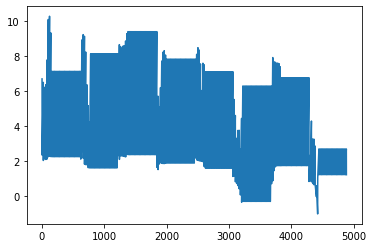

In [146]:
# date cannot be added right now
sub1['daily_dispatch_count'].plot()

In [149]:
sub1['daily_dispatch_count'].describe(), ware1['daily_dispatch_count'].describe()

(count    490.000000
 mean     4.214926  
 std      3.047922  
 min     -1.014838  
 25%      1.744457  
 50%      2.371296  
 75%      7.141868  
 max      10.290265 
 Name: daily_dispatch_count, dtype: float64,
 count    1702.000000
 mean     6.212926   
 std      3.742868   
 min      0.000000   
 25%      3.600000   
 50%      5.150000   
 75%      9.200000   
 max      17.900000  
 Name: daily_dispatch_count, dtype: float64)

* The predictions shows that dispatch count for this warehouse can go till 17.9 and could also have 0 in between.

In [135]:
sub_main = pd.concat([sub1,sub2,sub3,sub4,sub5,sub6,sub7,sub8,sub9,sub10], axis=0).sort_index()
test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)

In [136]:
sub_main['warehouse_ID'] = test_df['warehouse_ID'] 
sub_main['date'] = test_df['date']
sub_main['ID'] = test_df['ID']
sub_main['Product_Type'] = test_df['Product_Type']

In [137]:
sub_main.head()

,daily_dispatch_count,warehouse_ID,date,ID,Product_Type
0,4.091804,WH_0x3e9,2021-05-01,0x31fc,Type_A
1,0.579612,WH_0x3e9,2021-05-01,0x31fd,Type_B
2,6.707429,WH_0x3ea,2021-05-01,0x3ed2,Type_A
3,2.350477,WH_0x3ea,2021-05-01,0x3ed3,Type_B
4,6.408754,WH_0x3eb,2021-05-01,0x4a3a,Type_A


In [138]:
sub_main.groupby('date')['daily_dispatch_count'].sum()

date
2021-05-01    75.316556
2021-05-02    74.745688
2021-05-03    75.324288
2021-05-04    76.022494
2021-05-05    77.832138
                ...    
2021-12-27    47.231114
2021-12-28    47.231114
2021-12-29    47.231114
2021-12-30    47.231114
2021-12-31    47.231114
Name: daily_dispatch_count, Length: 245, dtype: float64

In [139]:
train_df['is_weekend'] = pd.to_datetime(train_df['date'],format = '%Y-%m-%d').dt.weekday.apply(lambda x: 'Yes' if x == 6 else 'No')
sub_main['is_weekend'] = pd.to_datetime(sub_main['date'],format = '%Y-%m-%d').dt.weekday.apply(lambda x: 'Yes' if x == 6 else 'No')

In [140]:
sub_main[sub_main['is_weekend'] == 'Yes'].shape

(700, 6)

In [141]:
sub = pd.read_csv('C:/projects/digit_prediction/tredence/data/submission_weekly.csv')
print(sub.shape)

(700, 2)


## Weekly_dispatch_count logic

In [142]:
prevdf = train_df[train_df['date']> '2021-04-25'][sub_main.columns]
subdf = pd.concat([prevdf,sub_main], axis=0).reset_index(drop=True)
subdf.head()

,daily_dispatch_count,warehouse_ID,date,ID,Product_Type,is_weekend
0,0.0,WH_0x3e9,2021-04-26,0x31f2,Type_A,No
1,0.0,WH_0x3e9,2021-04-26,0x31f3,Type_B,No
2,3.6,WH_0x3ea,2021-04-26,0x3ec8,Type_A,No
3,4.8,WH_0x3ea,2021-04-26,0x3ec9,Type_B,No
4,3.1,WH_0x3eb,2021-04-26,0x4a30,Type_A,No


In [143]:
# subdf[subdf['date']=='2017-01-08']
subss = []
weekdays =  subdf[subdf['is_weekend']=='Yes']['date'].unique()
neweek = pd.Series(data = [None]*(subdf.shape[0]))
# pre_index = 0
# for i in range(len(weekdays)):
i = 0
while i <  len(weekdays) :
    if i == 0:
        df = subdf[(subdf['date'] <= weekdays[i])]

    # elif i == len(weekdays) -1:
    #     df = subdf[(subdf['date'] <= weekdays[i]) & (subdf['date'] > weekdays[i-1])]
    else:
        df = subdf[(subdf['date'] <= weekdays[i]) & (subdf['date'] > weekdays[i-1])]
    # print(df['date'].unique())
    # print(df)
    # print('df shape',df.shape)
    # n_rows = df.shape[1]
    # index = df[df['is_weekend'] == 'Yes'].index
    
    dispatch_ = df.groupby(['warehouse_ID','Product_Type'])['daily_dispatch_count'].sum()
    dispatch = dispatch_.values
    # print('dispatches',len(dispatch), dispatch_)
    # print(dispatch)
    # neweek.iloc[index] = dispatch
    subss.append(dispatch)
    # neweek[pre_index: pre_index+n_rows] =  dispatch
    # pre_index += n_rows 
    i+=1


In [144]:
serw  = np.concatenate([x.ravel() for x in subss])
serw.shape

(700,)

## test submission main

In [145]:
sub_ = sub.copy()
sub_['weekly_dispatch_count'] = pd.Series(serw)
sub_
sub_.fillna(0,inplace=True)
sub_.to_csv('submission13.csv',index=False)